## Fine-Tuned MobileNet On Custom Data Set

#### Imports and GPU config

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

2023-05-28 18:10:24.610922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

2023-05-28 18:10:28.669146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 18:10:28.669527: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 18:10:28.670026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-28 18:10:28.681740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 18:10:28.681857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

Num GPUs Available:  1


2023-05-28 18:10:29.068854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-05-28 18:10:29.068876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2023-05-28 18:10:29.068881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2023-05-28 18:10:29.069050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 18:10:29.069251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 18:10:29.069352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-

### Organize The Data
With code, we'll create the directories for the train, validation, and test sets, organize the images into their respective classes of 0 through 9 on disk, and then shuffle the data set and split the images into train, validation, and test sets.

In [4]:
# Organize the data into train, valid, test dirs
os.chdir('../../data/Sign-Language-Digits-Dataset/')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')    # the f is for converting the numbers in f-strings. An f-string is a way to embed expressions inside string literals, allowing you to dynamically insert variable values or expressions directly into the string.
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30) # the random.sample() function selects a random sample of 30 elements for the provided list
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5) # the random.sample() function selects a random sample of 5 elements for the provided list
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')

os.chdir('../../src/MobileNet/')



In [11]:
# we create the directory iterators for the train, validation and test sets

train_path='../../data/Sign-Language-Digits-Dataset/train'
valid_path='../../data/Sign-Language-Digits-Dataset/valid'
test_path='../../data/Sign-Language-Digits-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


note that the ImageDataGenerator recognizes ten classes

## Build the fine-tuned MobilNet model

In [12]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [13]:
# Next, we're going to grab the output from the fifth to last layer of the model and store it in this variable x
x=mobile.layers[-6].output

By looking at the summary of the original model, we can see that by not including the last four layers, we'll be including everything up to and including the last global_average_pooling layer.

**Note** that the amount of layers that we choose to cut off when you're fine-tuning a model will vary for each scenario

Now, we'll be using this to build a new model

In [14]:
# We need to reshape our output from the global_average_pooling layer that we will pass to our output layer, which we're calling output
x = tf.keras.layers.Reshape(target_shape=(1024,), name='reshape_1')(x)
output = Dense(units=10, activation='softmax', name='dense')(x)

# We create the new fine-tuned MobileNet model
model = Model(inputs=mobile.input, outputs=output)

**Note** the Model constructor used to create our model, is a model that is being created with the Keras Functional API, not the Sequential API

To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original MobileNet, and then we define the outputs of the model to be equal to the output variable we created directly above.

This creates a new model, which is identical to the original MobileNet up to the original model's sixth to last layer. We don't have the last five original MobileNet layers included, but instead we have a new layer, the output layer we created with ten output nodes.

### Freezing weights

Now, we need to choose how many layers we actually want to be trained when we train on our new data set.

We still want to keep a lot of what the original MobileNet has already learned from ImageNet by freezing the weights in many of layers, especially earlier ones, but we do indeed need to train some layers since the model still needs to learn features about this new data set.

The experimentation will say how many layers is necessary to freeze. In this case we found out that **training the last 22 layers** will give us a pretty decent performance:

In [15]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

## Train the model

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10


2023-05-28 18:13:34.523258: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.16G (3388407808 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 18:13:34.615395: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.16G (3388407808 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 18:13:34.615756: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.16G (3388407808 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 18:13:34.616254: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.16G (3388407808 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 18:13:34.616264: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


343/343 - 14s - loss: 0.6354 - accuracy: 0.8213 - val_loss: 0.1674 - val_accuracy: 0.9667
Epoch 2/10
343/343 - 5s - loss: 0.1497 - accuracy: 0.9673 - val_loss: 0.0856 - val_accuracy: 0.9767
Epoch 3/10
343/343 - 5s - loss: 0.0827 - accuracy: 0.9854 - val_loss: 0.0756 - val_accuracy: 0.9700
Epoch 4/10
343/343 - 5s - loss: 0.0510 - accuracy: 0.9924 - val_loss: 0.0534 - val_accuracy: 0.9867
Epoch 5/10
343/343 - 5s - loss: 0.0412 - accuracy: 0.9953 - val_loss: 0.0364 - val_accuracy: 0.9833
Epoch 6/10
343/343 - 5s - loss: 0.0313 - accuracy: 0.9959 - val_loss: 0.0440 - val_accuracy: 0.9767
Epoch 7/10
343/343 - 5s - loss: 0.0171 - accuracy: 0.9982 - val_loss: 0.0334 - val_accuracy: 0.9900
Epoch 8/10
343/343 - 5s - loss: 0.0220 - accuracy: 0.9959 - val_loss: 0.0236 - val_accuracy: 0.9933
Epoch 9/10
343/343 - 5s - loss: 0.0159 - accuracy: 0.9971 - val_loss: 0.0237 - val_accuracy: 0.9933
Epoch 10/10
343/343 - 5s - loss: 0.0131 - accuracy: 0.9977 - val_loss: 0.0250 - val_accuracy: 0.9900


## Inference data

In [28]:
predictions=model.predict(x=test_batches, steps=len(test_batches), verbose=0)

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


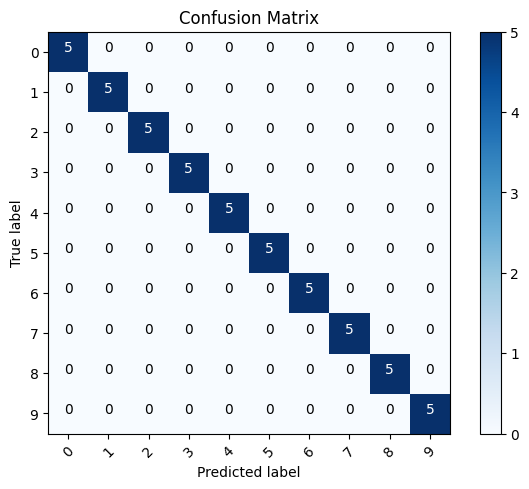

In [29]:
import plot_confusion_matrix as pcm

test_labels = test_batches.classes

cm=confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']

pcm.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
